In [40]:
import ast
import os
import sys
import matplotlib.pyplot as plt

import seaborn as sns
parent_dir = "/Volumes/work/phd/MoLFormer_N2024"
sys.path.append(parent_dir)
base_dir= '../../../../T5 EVO/'
from constants import sagar_tasks

In [20]:
import os
import numpy as np
import pandas as pd
base_path = '../../../../T5 EVO/alignment_olfaction_datasets/'
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import scipy

In [21]:
def custom_ridge_regression(X, y, seed):
    linreg = RidgeCV()
    estimator = linreg.fit(X, y)
    return estimator

In [22]:
def metrics_per_descritor(X, y, linreg):
    predicted = linreg.predict(X)
    mseerrors = []
    correlations = []
    if len(y.shape) > 1:
        for i in range(y.shape[1]):
            mseerror = mean_squared_error(predicted[:, i], y[:, i])
            
            correlation = scipy.stats.pearsonr(predicted[:, i], y[:, i])
            
                
            mseerrors.append(mseerror)
            correlations.append(correlation)

    else:
        mseerror = mean_squared_error(predicted, y)
        correlation = scipy.stats.pearsonr(predicted, y)
        mseerrors.append(mseerror)
        correlations.append(correlation)
        
        

    return predicted, mseerrors, correlations

In [23]:
def select_features(input_file):
    ds_alva = pd.read_csv(input_file)


    chemical_features_r=["nCIR",
                     "ZM1", 
                     "GNar", 
                     "S1K", 
                     "piPC08",
                     "MATS1v",
                     "MATS7v",
                     "GATS1v", 
                     "Eig05_AEA(bo)", 
                     "SM02_AEA(bo)",
                     "SM03_AEA(dm)",
                     "SM10_AEA(dm)",
                     "SM13_AEA(dm)",
                      "SpMin3_Bh(v)",
                     "RDF035v",
                     "G1m",
                     "G1v",
                     "G1e",
                     "G3s",
                     "R8u+",
                     "nRCOSR"]

    nonStereoSMILE = list(map(lambda x: "nonStereoSMILES___" + x, chemical_features_r))
    # IsomericSMILES = list(map(lambda x: "IsomericSMILES___" + x, chemical_features_r))
    selected_features = nonStereoSMILE
    features= ['CID','nonStereoSMILES']+selected_features
    # print("cc1", ds_alva.columns.values.tolist())
    ds_alva= ds_alva.rename(columns={"cid":"CID"})
    # print("cc2", ds_alva.columns.values.tolist())
    ds_alva_selected = ds_alva[features]
    ds_alva_selected = ds_alva_selected.fillna(0)
    ds_alva_selected['embeddings'] = ds_alva_selected[selected_features].values.tolist()
    return ds_alva_selected


In [24]:
sagar_descriptors = ['0.1',
     '1.1',
     '2.1',
     '3.1',
     '4.1',
     '5.1',
     '6.1',
     '7.1',
     '8.1',
     '9.1',
     '10.1',
     '11.1',
     '12.1',
     '13.1',
     '14.1'
     ]


sagar_descriptors2 = [
     '0',
     '1',
     '2',
     '3',
     '4',
     '5',
     '6',
     '7',
     '8',
     '9',
     '10',
     '11',
     '12',
     '13',
     '14'
     ]

In [25]:
def prepare_dataset(ds,x_att,y_att):
    ds[y_att] = ds[y_att].apply(ast.literal_eval)
    ds[x_att] = ds[x_att].apply(ast.literal_eval)
    return ds

In [26]:
def grand_average(df, ds):
    if ds == "sagar":
        descriptors = sagar_descriptors
    elif ds == "sagar2":
        descriptors = sagar_descriptors2
    else:
        raise ValueError("Invalid dataset")

    df_groupbyCID = df.groupby('CID')[descriptors].mean().reset_index()

    df_groupbyCID['y'] = df_groupbyCID.loc[:, descriptors[0]:descriptors[-1]].values.tolist()
    df_embeddings = df.drop_duplicates(subset=['CID'])
    df_embeddings = df_embeddings[['CID', 'embeddings']]
    df_groupbyCID = pd.merge(df_groupbyCID, df_embeddings, on='CID', how='left')
    return df_groupbyCID


In [27]:
def train_and_eval(data,times,n_components=None):
    mserrorrs_corssvalidated = []
    correlations_corssvalidated = []
    predicteds = []
    y_tests = []
    runs = []
    CIDs = []
    
    
    
    X=np.asarray(data.y.values.tolist())
    y=np.asarray(data.fmri_average.values.tolist())
    
    for i in range(times):
        X_train, X_test, y_train, y_test,CID_train, CID_test = train_test_split(X,y ,data.CID, test_size=0.2, random_state=seed+i) 
        # print(X_train.shape,X_test.shape)
        linreg = custom_ridge_regression(X_train, y_train, seed)
        
        
        predicted, mseerrors, correlations=metrics_per_descritor(X_test,y_test,linreg)
        mserrorrs_corssvalidated.append(mseerrors)
        correlations_corssvalidated.append(correlations)
        predicteds.extend(predicted)
        y_tests.extend(y_test)
        runs.extend([i]*len(y_test))
        CIDs.extend(CID_test)
        
        
    return CIDs,predicteds,y_tests,runs,mserrorrs_corssvalidated, correlations_corssvalidated

In [28]:
def post_process_results_df(mserrorrs_corssvalidated, correlations_corssvalidated):
    mserrorrs_corssvalidated_array = np.asarray(mserrorrs_corssvalidated)
    if len(mserrorrs_corssvalidated_array.shape) == 3:
        mserrorrs_corssvalidated_array = np.squeeze(mserrorrs_corssvalidated_array, -1)
        mserrorrs_corssvalidated_array = np.moveaxis(mserrorrs_corssvalidated_array, 0, 1)
    # print(mserrorrs_corssvalidated_array.shape,"shapeeee1")

    correlations_corssvalidated = np.asarray(correlations_corssvalidated)
    if len(correlations_corssvalidated.shape) == 4:
        correlations_corssvalidated = np.moveaxis(correlations_corssvalidated, 0, 1)
        # print("correlations_corssvalidateds",correlations_corssvalidated.shape)
        correlations_corssvalidated = np.squeeze(correlations_corssvalidated, 2)
    # print(correlations_corssvalidated.shape,"shapeeee2")
    statistics_correlations_corssvalidated_array = correlations_corssvalidated[:, :, 0]
    pvalues_correlations_corssvalidated_array = correlations_corssvalidated[:, :, 1]

    return mserrorrs_corssvalidated_array, statistics_correlations_corssvalidated_array, pvalues_correlations_corssvalidated_array



In [29]:
def pipeline(fmri_ev,voxel, input_file_behavior,times=30,n_components=None):
    df_predictions,df_df_mse, df_df_cor = None,None,None
    
    # input_file_keller = base_path+'openpom/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_13_Apr17.csv'
    fmri_ev_voxel = fmri_ev[fmri_ev.voxel == voxel]
    df=pd.read_csv(input_file_behavior)
    df=prepare_dataset(df,'embeddings','y')
    df_groupbyCID=grand_average(df,'sagar')
    # df_groupbyCIDSubject=average_over_subject(df,'sagar')
    
    

    
    df = pd.merge(df_groupbyCID,fmri_ev_voxel,on='CID')
    
    
    
    CIDs, predicteds, y_tests,runs, mserrorrs_df_corssvalidated, correlations_df_corssvalidated=train_and_eval(df,times=times,n_components=n_components)
    # print(np.asarray(predicteds).shape,np.asarray(y_tests).shape, np.asarray(runs).shape, np.asarray(CIDs).shape)
    mserrorrs_corssvalidated_df,statistics_correlations_corssvalidated_df,pvalues_correlations_corssvalidated_df=post_process_results_df(mserrorrs_df_corssvalidated, correlations_df_corssvalidated)
    df_df_mse= pd.DataFrame(mserrorrs_corssvalidated_df)
    # df_df_mse = df_df_mse.T
    
    df_df_mse['voxel'] = voxel
    df_df_mse['type'] = 'mse'
    df_df_cor= pd.DataFrame(statistics_correlations_corssvalidated_df)
    
    df_df_cor['voxel'] = voxel
    df_df_cor['type'] = 'cor'
    
    df_metric = pd.concat([df_df_cor,df_df_mse])
    

    df_predictions = pd.DataFrame(np.concatenate([np.asarray(CIDs).reshape(-1,1),np.asarray(predicteds),np.asarray(y_tests),np.asarray(runs).reshape(-1,1)],axis=1))
    df_predictions['voxel'] = voxel
    #and add a prefix to the columns to indicate the predicted vs true values
    df_predictions.columns = ['CID']+[str(i)+'_predicted' for i in range(11)]+[str(i)+'_true' for i in range(11)]+['run']+['voxel']
    
    
    return df_predictions,df_metric

In [30]:
def compute_correlation(times,n_components,fmri_ev,input_file_behavior):
   
    metrics=[]
    predictions=[]
    

    for voxel in fmri_ev.voxel.unique():
       
        df_predictions, df_metric= pipeline(fmri_ev,voxel,input_file_behavior,times=times,n_components=n_components)
        metrics.append(df_metric)
        predictions.append(df_predictions)
              
        
    return metrics,predictions

In [31]:
def save_data(ds,metrics):

    
    #concatenate a list of dataframes vertically
    metrics = pd.concat(metrics)
    # metrics_pom.columns = columns+["model" , "voxel"]
    metrics.to_csv(ds+'_behavior.csv', index=False)  

In [32]:
def safe_literal_eval(array_str):
# array_3d = np.array(list_3d)
#     cleaned_str = array_str.replace('\n', ',').replace(' ', ',').replace(',,', ',').replace(',,,', ',').replace(',,', '').replace('[,', '[').strip()
    cleaned_str = array_str.replace('\n', ',').replace('   ', ',').replace('  ', ',').replace(' ', ',').replace(',,,', ',').replace(',,', ',').replace('[,', '[')
#  
# # Step 3: Convert string back to a Python list (use ast.literal_eval for safety)
    try:
        list_3d = ast.literal_eval(cleaned_str)
        # print(np.asarray(list_3d).shape)
    except SyntaxError:
        print(f"SyntaxError: {array_str}")
        print(f"SyntaxError: {cleaned_str}")
# 
# # Step 4: Convert the list to a NumPy array
    array_3d = np.asarray(list_3d)
    return array_3d

def average(array_3d):
    return np.mean(array_3d,axis=0)

In [33]:
seed = 2024

In [16]:
def read_fmri_ev(roi,s):
    fmri_ev = pd.read_csv(f'{base_dir}fmri/csvs/fmrii_all_voxels_ev_{roi}_S{s}.csv')
    fmri_ev['ev'] = fmri_ev['ev'].apply(lambda x: eval(x)[0])
    fmri_ev.rename(columns={'condition':'CID'},inplace=True)
    fmri_ev['fmri'] = fmri_ev['fmri'].apply(safe_literal_eval)#convert fmri_ev['fmri'][0] to a 3d array
    fmri_ev['fmri_average'] = fmri_ev['fmri'].apply(average)
    return fmri_ev

In [17]:
input_file_behavior = base_dir+'alignment_olfaction_datasets/curated_datasets/tasks/curated_sagar_subjects_nonaminus.csv'
input_file_sagar_pom = base_path+'curated_datasets/embeddings/pom/sagar_pom_embeddings_Apr17.csv'

for i in [1,2,3]:
    for roi in [ 'OFC']:
        print(i,roi)
        fmri_ev = read_fmri_ev(roi,i )
        times =30
        n_components = 20
        metrics,predictions=compute_correlation(times , n_components,fmri_ev[['fmri_average','CID','voxel']],input_file_sagar_pom)
        save_data(f'{base_dir}fmri/csvs/fmri_sagar_behavior_metrics_{roi}_S{i}',metrics)   

1 OFC


KeyboardInterrupt: 

## Visualization

In [42]:
def post_process_dataframe( corrss_finetuned,msess_finetuned, tasks,
                           figure_name="def",width=None,linewidth=3,fontsize=45,yticks_cor=[0,0.1,0.2,0.3,0.4],yticks_mse=[0,0.05,0.1,0.15,0.2],type='des_regression'):

    plt.rcParams["font.size"] = fontsize

    f2, ax = plt.subplots(2, 1, figsize=(22, 22))

   

    g1 = combine_visualize((corrss_finetuned), tasks, ax[0], 'Correlation Coefficient',
                           figure_name="Correlation_" + figure_name,abs=True,width=width,linewidth=linewidth,yticks=yticks_cor,fontsize=fontsize)

    # combine_visualize_separate(msess.loc[msess["layer"]==12].iloc[:,msess.columns != 'layer'], df_mse_pom,df_mse_alva,tasks,ax_agg[1],'MSE',type="mse",figure_name="MSE_Avg_"+figure_name)
    g2 = combine_visualize(( msess_finetuned), tasks, ax[1], 'NRMSE', figure_name="MSE__" + figure_name,width=width,linewidth=linewidth,yticks=yticks_mse,fontsize=fontsize)
    vertical_plot_tweak(f2, figure_name, g1, g2,fontsize,type)

    # return melted_corrss_filtered
def vertical_plot_tweak(f2, figure_name, g1, g2,fontsize,type):
    g1.set_xlabel('')
    g2.set_xlabel('Descriptor')
    g1.legend().set_title("Model")
    # handles, labels = g1.get_legend_handles_labels()
    g1.get_legend().remove()
    g2.legend().set_title("Model")
    handles, labels = g2.get_legend_handles_labels()
    g2.get_legend().remove()
    print(labels)
    f2.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.95)
    labels = ['MoLFormer', 'Open-POM', 'DAM','Fine-tuned MoLFormer']
    plt.rcParams["font.size"] = fontsize
    if type == 'chem_regression':
        bbox_to_anchor = (0.52, -.13)
        hspace = 0.86

    elif type == 'des_regression':
        bbox_to_anchor = (0.52, -0.09)
        hspace = 0.6
    else:
        raise ValueError('Invalid type')
    f2.legend(handles, labels, ncol=4, columnspacing=1, prop={'size': fontsize}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=bbox_to_anchor,

              frameon=True, labelspacing=0.4, handletextpad=0.2, )

    plt.subplots_adjust(hspace=hspace)


    # plt.legend(title='Smoker', loc='upper left',)

    f2.savefig(figure_name + ".pdf", bbox_inches='tight')


In [71]:
def combine_visualize(df_combined, tasks, ax, title, abs=False, figure_name="def",width=None,linewidth=7,yticks=None,fontsize=45):
    plt.rcParams["font.size"] = fontsize
    # df_combined = pd.concat(dfs)
    # df_combined = df_combined.iloc[:, df_combined.columns != 'type']
    # df_combined = df_combined.iloc[:, df_combined.columns != 'voxel']

    melted_df_keller = df_combined.melt(id_vars=['type','voxel'], var_name='descritpor')
   
    
    g1 = sns.barplot(
        data=melted_df_keller,
        x="descritpor", y="value",
        errorbar="se", ax=ax, palette=['#4d79a4', '#ecc947', '#b07aa0','#103961'],linewidth=linewidth)


    if width is not None:
        for patch in g1.patches:
            patch.set_width(width)  # Set the desired width


    g1.spines['top'].set_visible(False)
    g1.spines['right'].set_visible(False)

    g1.set_xticklabels(tasks, rotation=90,size=fontsize)
    g1.set_yticks(yticks)
    g1.set_yticklabels([str(i) for i in yticks],size=fontsize)

    g1.set_xlabel('Descriptor', fontsize=fontsize)
    g1.set_ylabel(title, fontsize=38)

    return g1

In [72]:
df_sagar_cor_behavior

,0,1,2,3,4,5,6,7,8,9,10,voxel,type
0,0.365324,-0.184603,0.078648,-0.016264,0.097706,-0.149630,-0.186647,-0.097436,0.091538,0.309706,0.074702,0,cor
1,0.133571,-0.224344,-0.084138,-0.277996,-0.005315,-0.152105,-0.110210,0.137907,0.039990,-0.011910,0.000945,0,cor
2,0.289424,0.015529,0.131864,-0.179490,0.051957,-0.070349,-0.085086,0.294827,0.079063,0.084540,0.135221,0,cor
3,0.222866,0.088588,0.139897,-0.185797,0.135925,-0.037768,-0.238497,0.271177,0.296556,-0.088639,-0.036955,0,cor
4,0.304229,0.141503,-0.188182,-0.176350,-0.200687,-0.150518,-0.221419,0.163930,-0.203308,-0.022093,0.148756,0,cor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26965,-0.063999,-0.089473,0.452271,0.045254,0.246494,0.058038,-0.147739,0.304348,0.033476,0.221625,-0.015521,449,cor
26966,-0.068311,-0.167376,0.214156,0.155199,0.269199,0.204595,-0.236653,0.021261,0.023992,0.084669,-0.043412,449,cor
26967,-0.212997,-0.111562,0.003595,0.120616,0.150058,0.214435,-0.177149,0.231766,-0.178889,-0.030173,-0.163628,449,cor
26968,-0.027370,-0.087876,0.280142,0.377810,0.199666,0.294160,-0.127651,-0.084401,-0.227676,0.147152,0.230194,449,cor


In [77]:
results_path = 'curated_datasets/dfs_result_fmri/'
file_name = 'APC_S1_'
df_sagar_metric_behavior=pd.read_csv(f'{base_path}{results_path}fmri_sagar_behavior_metrics_{file_name}behavior.csv')
df_sagar_cor_behavior = df_sagar_metric_behavior[df_sagar_metric_behavior['type']=='cor']
df_sagar_mse_behavior = df_sagar_metric_behavior[df_sagar_metric_behavior['type']=='mse']

/var/folders/s8/bznqh0v13ddg31lz919tkrmc0000gn/T/ipykernel_82466/2786306200.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g1 = sns.barplot(
/var/folders/s8/bznqh0v13ddg31lz919tkrmc0000gn/T/ipykernel_82466/2786306200.py:10: UserWarning: 
The palette list has fewer values (4) than needed (11) and will cycle, which may produce an uninterpretable plot.
  g1 = sns.barplot(
/var/folders/s8/bznqh0v13ddg31lz919tkrmc0000gn/T/ipykernel_82466/2786306200.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(tasks, rotation=90,size=fontsize)
/var/folders/s8/bznqh0v13ddg31lz919tkrmc0000gn/T/ipykernel_82466/2786306200.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

[]


FileNotFoundError: [Errno 2] No such file or directory: 'figs/sagar_regression_fmri_APC_S10.pdf'

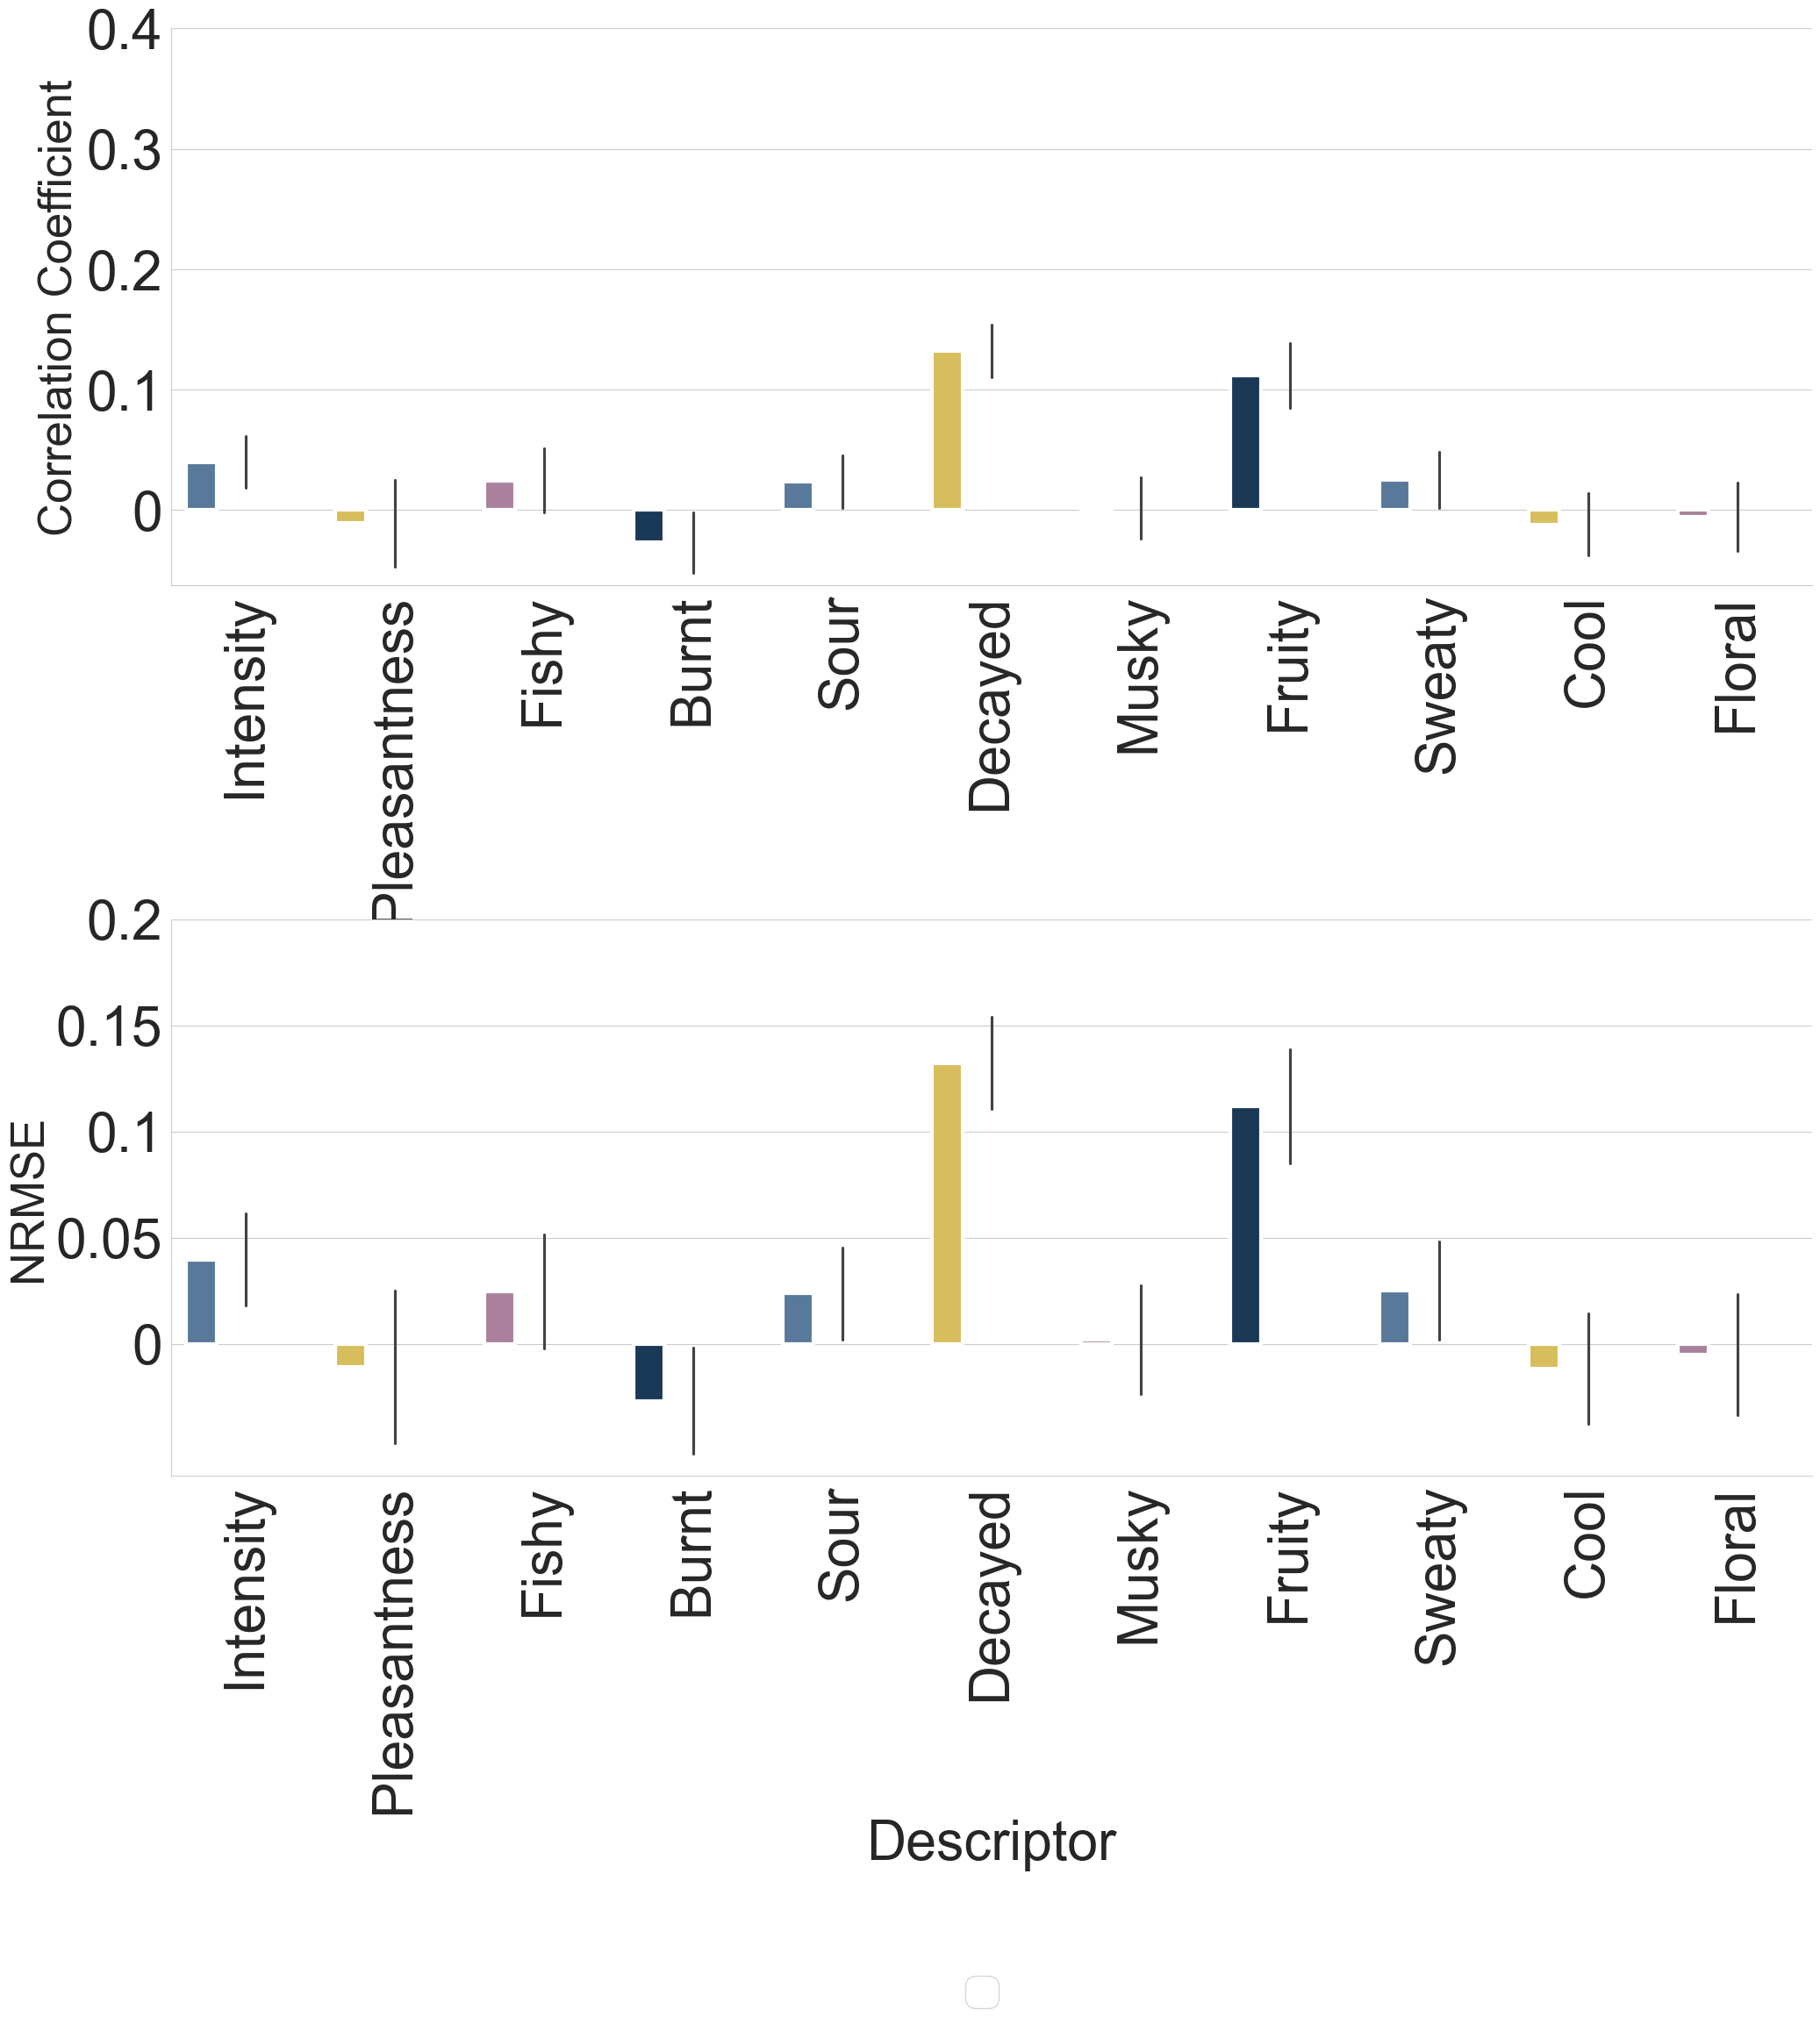

In [78]:
for voxel in df_sagar_cor_behavior['voxel'].unique():
    df_sagar_corrs_molfomer_voxel = df_sagar_cor_behavior[df_sagar_cor_behavior['voxel']==voxel]
    df_sagar_mse_molfomer_voxel = df_sagar_cor_behavior[df_sagar_cor_behavior['voxel']==voxel]
    trend_learning_molformer_sagar = post_process_dataframe(df_sagar_corrs_molfomer_voxel,df_sagar_mse_molfomer_voxel,sagar_tasks,"figs/sagar_regression_fmri_APC_S1"+str(voxel),width=0.21)

In [57]:
melted_df_keller = df_sagar_cor_behavior.melt(id_vars=['type','voxel'], var_name='descritpor')
   

In [58]:
melted_df_keller

,type,voxel,descritpor,value
0,cor,0,0,0.365324
1,cor,0,0,0.133571
2,cor,0,0,0.289424
3,cor,0,0,0.222866
4,cor,0,0,0.304229
...,...,...,...,...
148495,cor,449,10,-0.015521
148496,cor,449,10,-0.043412
148497,cor,449,10,-0.163628
148498,cor,449,10,0.230194
